# Knowledge Distillation(지식 증류)

간단한 증류 시험 장치
1. 가열 장치
2. 혼합물이 들어 있는 플라스크
3. 기화된 물질의 이동통로
4. 온도계
5. 냉각기구
6. 냉각수 입구
7. 냉각수 출구
8. 증류되어 분리된 물질
9. 기체 배출구
10. 분리된 물질 유입구
11. 온도 조절 스위치
12. 교반 조절 스위치
13. 가열기 받침
14. 중탕 장비(기름 또는 모래)
15. 혼합물
16. 냉각조

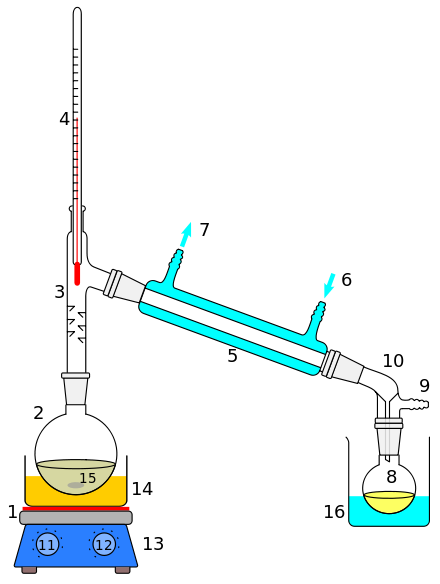

## 지식 증류 소개

지식 증류는 작은(학생) 모델이 사전 훈련된 큰(교사) 모델과 일치하도록 훈련되는 모델 압축 절차입니다. 지식은 손실 함수를 최소화하여 교사 모델에서 학생에게 전달되며, 이는 부드러운 교사 로짓과 실제 레이블을 일치시키는 것을 목표로 합니다.

소프트맥스에 "온도" 스케일링 기능을 적용하여 로짓을 부드럽게 하여 확률 분포를 효과적으로 평활화하고 교사가 학습한 클래스 간 관계를 드러냅니다.

**참조:**

- [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

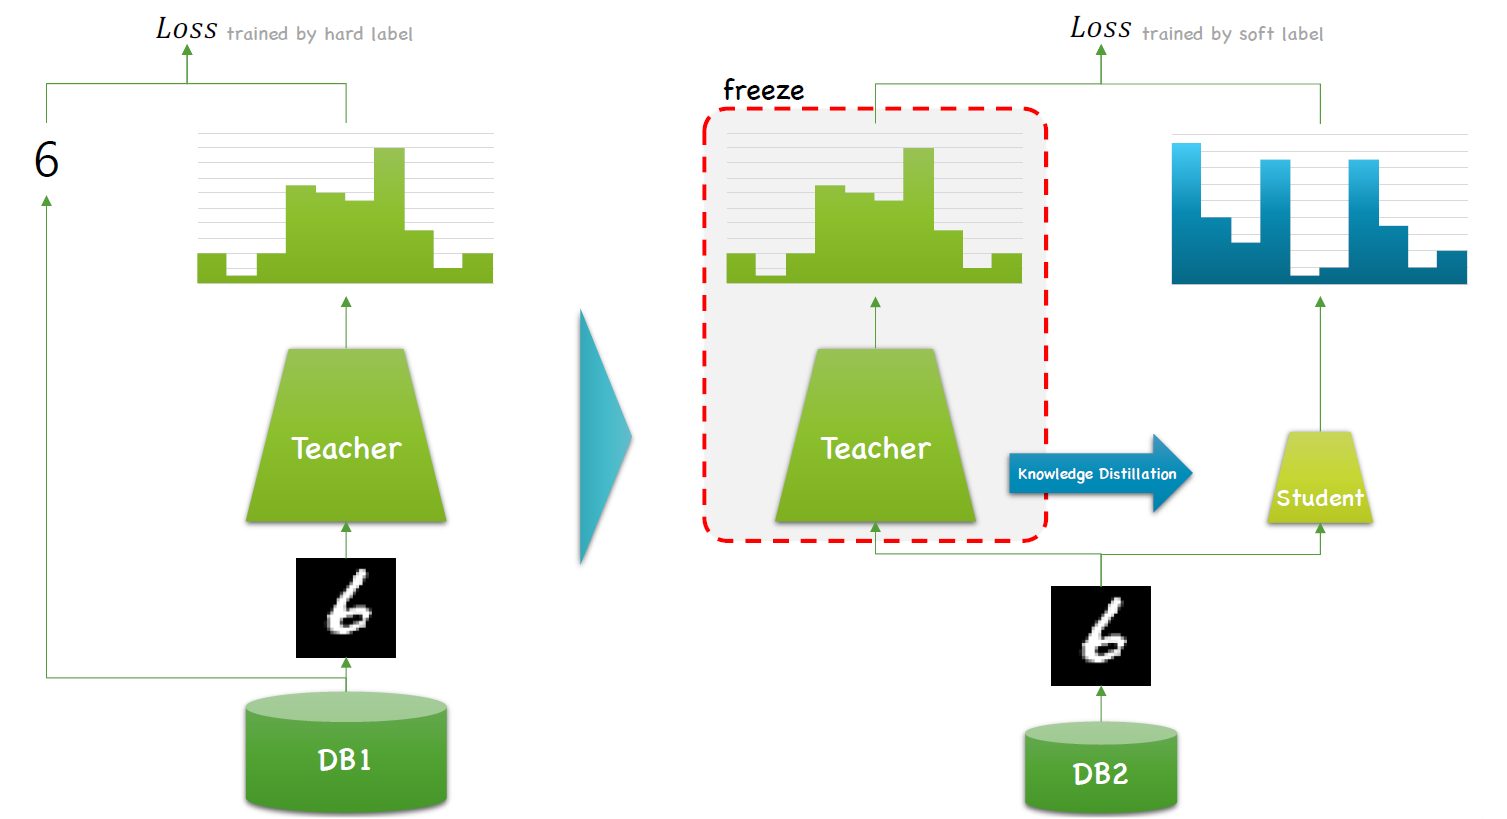

## 설정

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## 클래스  `Distiller()` 생성

사용자 정의  `Distiller()` 클래스 `Model` 은 `train_step`, `test_step`,
및 `compile()`. 증류기를 사용하려면 다음이 필요합니다.

- 훈련된 교사 모델
- 훈련할 학생 모델
- 학생 예측과 실제의 차이에 대한 학생 손실 함수
- temperature소프트 학생 예측과 소프트 교사 레이블 간의 차이에 대한 , 와 함께 증류 손실 함수
- alpha학생 및 증류 손실에 가중치를 주는 요소
- 학생용 옵티마이저 및 성과 평가를 위한 (선택 사항) 메트릭

이 train_step방법에서는 교사와 학생 모두 정방향 패스를 수행하고 , 에 의해 student_loss및 에 가중치를 부여하여 손실을 계산 하고 역방향 패스를 수행합니다. 참고: 학생 가중치만 업데이트되므로 학생 가중치에 대한 기울기만 계산합니다.distillation_lossalpha1 - alpha

이 test_step방법에서는 제공된 데이터 세트에서 학생 모델을 평가합니다.

In [2]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1), # (32,10)
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


## 학생 및 교사 모델 만들기

먼저 교사 모델과 더 작은 학생 모델을 만듭니다. 두 모델 모두 컨볼루션 신경망이며 를 사용하여 생성 `Sequential()` 되었지만 모든 Keras 모델이 될 수 있습니다.

In [3]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"), # (None,28,28,1)(3,3,1,256)+(256,)
        layers.LeakyReLU(alpha=0.2),                                
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"), 
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"), # (None,14,14,256)(3,3,256,512)+(512,)
        layers.Flatten(),                      #(None,7,7,512) => (None,25088)
        layers.Dense(10),                      # (None,25088)(25088,10)+(10,) => (None,10)
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [5]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         1180160   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 10)                250890    
                                                           

In [6]:
student.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                15690     
                                                           

## 데이터세트 준비

교사를 훈련하고 교사를 추출하는 데 사용되는 데이터 세트는
[MNIST](https://keras.io/api/datasets/mnist/), 이며 절차는 적절한 모델 선택이 있는 다른 데이터 세트(예:  [CIFAR-10](https://keras.io/api/datasets/cifar10/)와 동일 합니다.
학생과 교사 모두 훈련 세트에서 훈련을 받고 테스트 세트에서 평가됩니다.

In [4]:
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [8]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## 교사 훈련

지식 증류에서 우리는 교사가 훈련되고 고정되어 있다고 가정합니다. 따라서 우리는 일반적인 방법으로 훈련 세트에 대해 교사 모델을 훈련하는 것으로 시작합니다.

In [9]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 17s 8ms/step - loss: 0.1428 - sparse_categorical_accuracy: 0.9566
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0.9731
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0810 - sparse_categorical_accuracy: 0.9764
Epoch 4/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.9791
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9814


In [10]:
teacher.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.9746


[0.09970063716173172, 0.9746000170707703]

## 학생에게 교사를 증류

우리는 이미 교사 모델을 훈련했으며 원하는 손실, 하이퍼파라미터 및 옵티마이저로 Distiller(student, teacher)인스턴스 를 초기화하고 교사를 학생에게 증류하기만 하면 됩니다.compile()

In [11]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(x_train, y_train, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 17s 9ms/step - sparse_categorical_accuracy: 0.9145 - student_loss: 0.3874 - distillation_loss: 0.1041
Epoch 2/3
1875/1875 [==============================] - 16s 9ms/step - sparse_categorical_accuracy: 0.9700 - student_loss: 0.1244 - distillation_loss: 0.0304
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.9775 - student_loss: 0.0876


[0.9775000214576721, 5.022389814257622e-05]

## 비교를 위해 처음부터 학생 교육

지식 추출로 얻은 성과를 평가하기 위해 교사 없이 처음부터 동등한 학생 모델을 훈련할 수도 있습니다.

In [7]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9289
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0991 - sparse_categorical_accuracy: 0.9702
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9780


[0.06198379024863243, 0.9779999852180481]

교사가 5개의 전체 epoch 동안 교육되고 학생이 이 교사에서 3개의 전체 epoch 동안 증류되는 경우 이 예에서는 동일한 학생 모델을 처음부터 교육하는 것과 비교하여, 심지어 교사 자체와 비교하더라도 성능 향상을 경험해야 합니다. 교사의 정확도는 약 97.6%, 처음부터 학습된 학생은 약 97.6%, 증류된 학생은 약 98.1%로 예상해야 합니다. 다른 가중치 초기화를 사용하려면 다른 시드를 제거하거나 시도하십시오.

#### 평균이 변수인 경우

<img src=https://blog.kakaocdn.net/dn/bdUOtn/btqGiSBcpWd/NunZUEdBeQphZPCWMpIAT0/img.gif width=400>

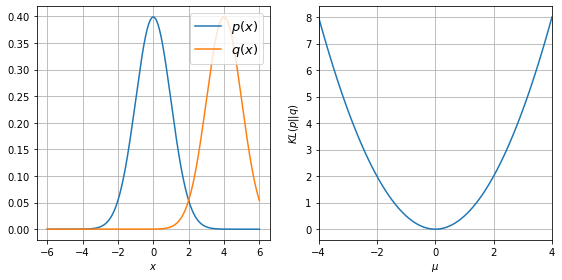

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 

def gaussian1d(x,μ,σ): 
    y = 1 / ( np.sqrt(2*np.pi* σ**2 ) ) * np.exp( - ( x - μ )**2 / ( 2 * σ ** 2 ) ) 
    return y 

def gaussian1d_KLdivergence(μ1,σ1,μ2,σ2): 
    A = np.log(σ2/σ1) 
    B = ( σ1**2 + (μ1 - μ2)**2 ) / (2*σ2**2) 
    C = -1/2 
    y = A + B + C 
    return y 

def KLdivergence(p,q,dx): 
    KL=np.sum(p * np.log(p/q)) * dx 
    return KL 

dx = 0.01 
xlm = [-6,6] 
x = np.arange(xlm[0],xlm[1]+dx,dx) 
x_n = len(x) 
μ1 = 0 
σ1 = 1 

px   = gaussian1d(x,μ1,σ1)
σ2 = 1 
U2 = np.arange(-4,5,1) 
U2_n = len(U2) 
Qx = np.zeros([x_n,U2_n]) 
KL_U2 = np.zeros(U2_n) 

for i,μ2 in enumerate(U2): 
    qx = gaussian1d(x,μ2,σ2) 
    Qx[:,i] = qx 
    KL_U2[i] = KLdivergence(px,qx,dx) 
    
U2_exc = np.arange(-4,4.1,0.1) 
KL_U2_exc = gaussian1d_KLdivergence(μ1,σ1,U2_exc,σ2) 
KL_U2_exc2 = U2_exc**2 / 2 

fig = plt.figure(figsize=(8,4)) 
clr=plt.rcParams['axes.prop_cycle'].by_key()['color'] 
ax = plt.subplot(1,2,1) 
plt.plot(x,px,label='$p(x)$') 
line,=plt.plot(x,Qx[:,i],color=clr[1],label='$q(x)$') 
plt.legend(loc=1,prop={'size': 13}) 
plt.xticks(np.arange(xlm[0],xlm[1]+1,2)) 
plt.xlabel('$x$') 
ax2 = plt.subplot(1,2,2) 
plt.plot(U2_exc,KL_U2_exc,label='Analytical') 
point, = ax2.plot([],'o',label='Numerical') 
plt.xlim([U2[0],U2[-1]]) 
plt.xlabel('$\mu$') 
plt.ylabel('$KL(p||q)$') 
plt.tight_layout() 

for a in [ax,ax2]: 
    plt.axes(a) 
    plt.grid() 
    plt.gca().set_aspect(1/plt.gca().get_data_ratio()) 
    
def update(i): 
    line.set_data(x,Qx[:,i]) 
    point.set_data(U2[i],KL_U2[i]) 
    ax.set_title("$\mu_2=%.1f$" % U2[i],fontsize=15) 
    ax2.set_title('$KL(p||q)=%.1f$' % KL_U2[i],fontsize=15) 
    
ani = animation.FuncAnimation(fig, update, interval=1000,frames=U2_n)


#### 표준편차가 변수인 경우

<img src=https://blog.kakaocdn.net/dn/b34d7O/btqGjekHqMF/29ukkkEtD6jZXOvKTx8yUK/img.gif width=400>

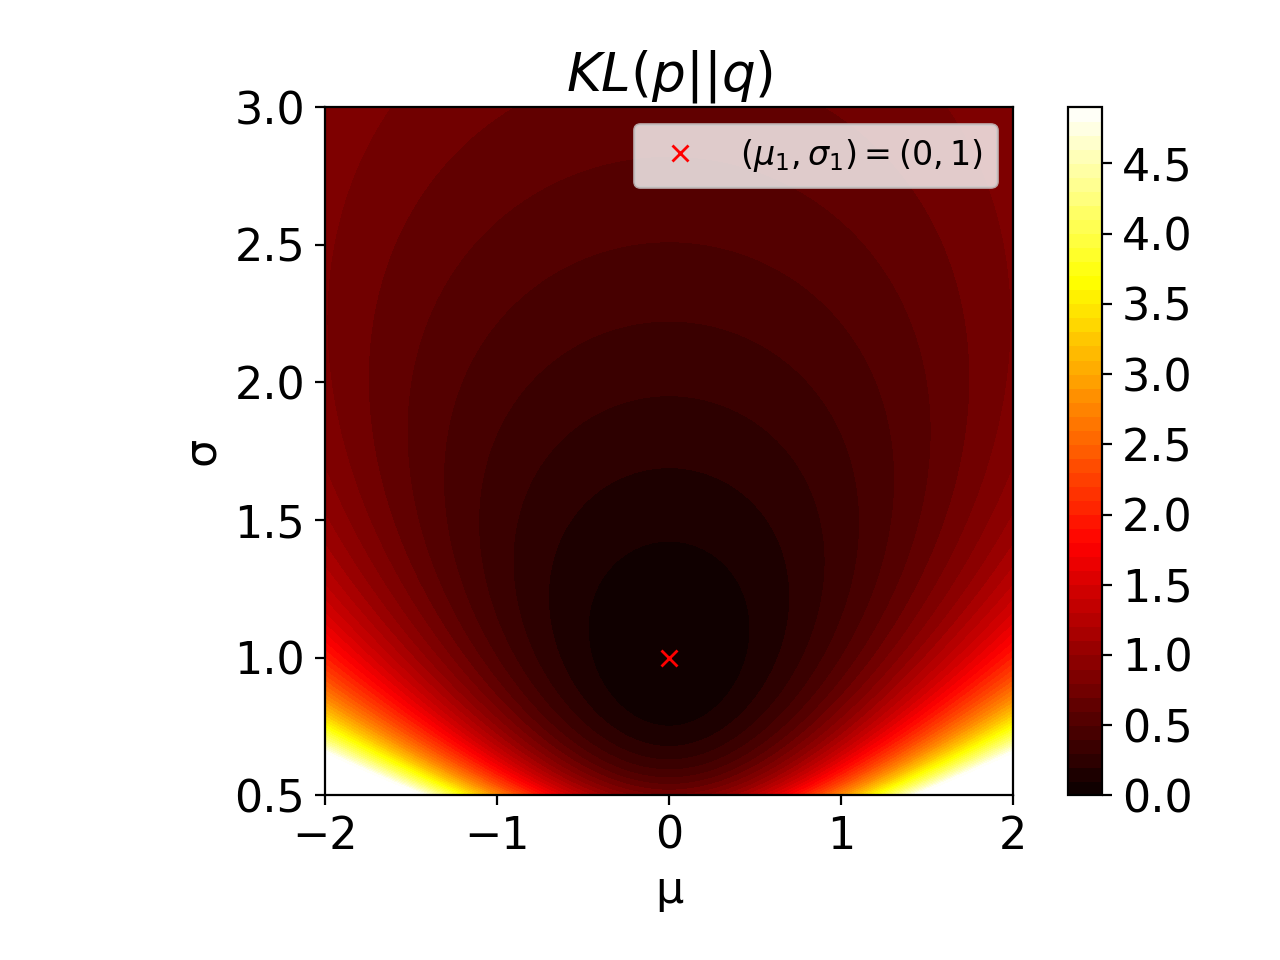

<img src=https://blog.kakaocdn.net/dn/b2fw9n/btqGnrplbS1/iQz8amh9Mpo8WndrVBCcu0/img.gif width=400>

### 지식 증류 모델 사용

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForQuestionAnswering
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = TFDistilBertForQuestionAnswering.from_pretrained('distilbert-base-cased')
input_ids = tf.constant(tokenizer.encode("Hello, my dog is cute"))[None, :]  # Batch size 1
outputs = model(input_ids)
start_scores, end_scores = outputs[:2]

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForQuestionAnswering: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['dropout_39', 'qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
